# 5. Gyakorlat: Mély $Q$-tanulás

In [1]:
%pip install torch

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Könyvtárak
import os
import gym
import random
import warnings
import matplotlib
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from matplotlib import animation
from collections import namedtuple
from scipy.signal import fftconvolve

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Konfigurációk
seed = 0
np.random.seed(seed)
random.seed(seed)
%matplotlib inline
matplotlib.rc('animation', html='jshtml')
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
warnings.filterwarnings('ignore')

## Segédfüggvények

In [3]:
# Jeleneti változó inicializálása
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch

# Képkockák lejátszása egymás után
def plot_animation(frames, repeat=True, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(fig, update_scene, fargs=(frames, patch), frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

# Mozgóátlagolás (gyors Fourier-transzformáció konvolúcióval)
def window_avg(lst, window_size):
    window_size = int(window_size)
    kernel = np.ones(window_size) / window_size
    return fftconvolve(lst, kernel, mode='valid')

# Gördülő átlagolás effektív implementációval
def rolling_avg(lst):
    lst_sum = np.cumsum(lst)
    lst_avg = lst_sum / (np.arange(len(lst)) + 1)
    return list(lst_avg)

# Állapot 1-hot kódolása (erre a diszkrét állapotok miatt van szükség - folytonos állapotok esetén nem szükséges)
def encode_state(s, n_obs):
    result = np.zeros(n_obs)
    result[s] = 1
    return result

---
## $Q$-hálózat az ügynökhöz

In [4]:
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):  # Architektúra definíció
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)  # Input réteg (teljesen becsatolt)
        self.fc2 = nn.Linear(64, 32)  # Rejtett réteg (teljesen becsatolt)
        self.fc3 = nn.Linear(32, 16)  # Rejtett réteg (teljesen becsatolt)
        self.fc4 = nn.Linear(16, action_size)  # Output réteg (teljesen becsatolt)
        
    def forward(self, s):  # Előrecsatolási csővezeték
        x = self.fc1(s)  # Első rétegen áramoltatás
        x = F.relu(x)  # Első réteg aktivációs függvénye (ReLu)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        return x

---
## Tapasztalat visszajátszás az ügynökhöz

In [5]:
class ReplayBuffer:
    def __init__(self, buffer_size, batch_size):
        self.batch_size = batch_size
        self.memory = deque(maxlen=buffer_size)
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])  # Nevesített tömb típus létrehozása
    
    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)  # Egy nevesített tömb létrehozása a megkapott paraméterekkel
        self.memory.append(e)
    
    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)  # Véletlen minta a memóriából

        # A véletlen minta átalakítása
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float()
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long()
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float()
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float()
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float()
  
        return states, actions, rewards, next_states, dones

    def __len__(self):  # Ha a __len__ függvény definiálva van le lehet kérdezni a struktúra hosszát a len() függvénnyel
        return len(self.memory)

---
## Ügynök

In [6]:
class Agent():
    def __init__(self, alpha, gamma, state_size, action_size, buffer_size, batch_size, update_every):
        # Belső paraméterek
        self.t_step = 0
        self.alpha = alpha  # Tanulási sebesség
        self.gamma = gamma  # Diszkont faktor
        self.batch_size = batch_size  # Kötegméret a tanuláshoz (ekkora mintát fog venni az ügynök a tapasztalat visszajátszásból)
        self.action_size = action_size  # Lehetséges cselekvések száma (ekkora lesz a Q-hálózat output rétege)
        self.buffer_size = buffer_size  # Buffer méret (összesen ennyi rekord lesz a tapasztalat memóriában)
        self.update_every = update_every  # Ennyi tanítási iterációnként fog történni egy tanítási lépés
        # Hálózat és belső memória
        self.qnetwork = QNetwork(state_size, action_size)  # Q-hálózat
        self.optimizer = optim.Adam(self.qnetwork.parameters(), lr=alpha)  # Optimalizáló algoritmus
        self.memory = ReplayBuffer(buffer_size, batch_size)  # Tapasztalat memória
        self.network_name = 'FrozenLake_DQN.pth'  # Fájlnév a modell fájlhoz
        # Követési struktúrák
        self.mse_track = []  # MSE hiba követése
        self.action_stack = np.zeros((0, 2))  # Cselekvések követése
        self.state_action_stack = np.zeros((0, action_size))  # Állapotok követése

    def step(self, s, a, r, sp, done):
        self.memory.add(s, a, r, sp, done)  # A tapasztalat hozzáadása a tapasztalati memóriához
        self.action_stack = np.vstack([self.action_stack, np.array([a, r])])
        self.t_step = (self.t_step + 1) % self.update_every  # Ha elér 0-hoz akkor tanítási ciklus fog történni

        if self.t_step == 0 and len(self.memory) > self.batch_size:  # Ha az ügynök elért egy tanítási iterációt és van elég összegyűlt tapasztalat
            experiences = self.memory.sample()  # A tapasztalat memória véletlen mintázása
            self.learn(experiences)  # Tanulás a tapasztalattal

    def act(self, s, eps):  # Cselekvés választása az állapot alapján
        s = torch.from_numpy(s).float().unsqueeze(0)
        self.qnetwork.eval()  # Hálózát átállítása kiértékelési módba
        with torch.no_grad():  # Predikció végrehajtása
            action_values = self.qnetwork(s)  
        self.qnetwork.train()  # Hálózat tanító módba állítása

        self.state_action_stack = np.vstack([self.state_action_stack, np.array(action_values)])  # Követési struktúrához hozzáfűzés

        p = np.random.random()
        if p < eps:  # Epszilon-mohó cselekvés választás
            return random.choice(np.arange(self.action_size))  # Véletlen cselekvés
        else:
            return np.argmax(action_values.cpu().data.numpy())  # Legjobb cselekvés az aktuális állapotból

    def learn(self, experiences):  # Ügynök tanulásának eljárása
        states, actions, rewards, next_states, dones = experiences  # Véletlen miniköteg kicsomagolása

        # Költség kiszámítása
        q_targets_next = self.qnetwork(next_states).detach().max(1)[0].unsqueeze(1)  # Q-értékek a következő állapotban
        q_targets = rewards + self.gamma * q_targets_next * (1 - dones)  # Q célértékek számítása
        q_expected = self.qnetwork(states).gather(1, actions)  # Q-értékek az aktuális állapotban
        
        # Költség számítása
        loss = F.mse_loss(q_expected, q_targets)  # Hiba kiszámítása (Ebben az esetben az átlagos négyzetes eltérés)
        self.mse_track.append(loss)  # Hiba hozzáadása a hiba követési struktúrájához
        self.optimizer.zero_grad()  # Gradiensek hozzájárulásának törlése a kötegelt költség számítása előtt
        loss.backward()  # Hiba visszaáramoltatása a hálózatba
        self.optimizer.step()  # Lépés végrehajtása az optimalizációs algoritmussal

    def save_network(self):
        torch.save(self.qnetwork.state_dict(), self.network_name) 
    
    def load_network(self):
        self.qnetwork.load_state_dict(self.network_name)

---
## Tanítás
### Paraméterek

In [7]:
max_t = 100  # Maximális időlépés egyetlen epizódon belül
max_i = 30000  # Epizódok száma
gamma = 0.99  # Diszkontálási faktor
alpha = 5e-4  # Tanulási sebesség 
eps_end = 0.0  # Felfedezési ráta kezdőértéke
eps_start = 1.0  # Felfedezési ráta végértéke
eps_decay = 0.9998  # Felfedezési ráta iterációnként ennyivel fog csökkenni
batch_size = 64  # Kötegméret - tapasztalat visszajátszásból vett minta mérete
update_every = 4  # Milyen gyakran frissüljön a hálózat
window_size = 50  # Jutalmak átlagolási ablakának mérete 
buffer_size = 100000  # Tapasztalat visszajátszás maximális mérete
success_thresh = .7  # Sikeresnek mondható a tanítás ha efölé az érték főlé emelkedik az ablakos jutalom

eps = eps_start  # Felfedezési ráta inicializálása
r_track = []  # Jutalmak követési struktúrája

env = gym.make(id = 'FrozenLake-v1', 
               desc = None, 
               map_name = "8x8", 
               is_slippery = True, 
               render_mode = 'rgb_array')  # Környezet

state_size = env.observation_space.n
action_size = env.action_space.n

agent = Agent(alpha = alpha, 
              gamma = gamma, 
              state_size = state_size, 
              action_size = action_size,
              buffer_size = buffer_size,
              batch_size = batch_size,
              update_every = update_every)  # Ügynök inicializálása

### Tanítás futtatása

In [8]:
for i in range(max_i):
    s = encode_state(env.reset()[0], state_size)
    done = False
    r_sum = 0

    for t in range(max_t):
        a = agent.act(s, eps)
        sp, r, done, info, _ = env.step(a)
        sp = encode_state([sp], state_size)
        agent.step(s, a, r, sp, done)
        r_sum += r
        s = sp
        if done:
            break

    r_track.append(r_sum)
    r_mean = round(np.mean(r_track[max(0, len(r_track) - window_size) : len(r_track) - 1]), 2)
    eps = eps * eps_decay if eps > eps_end else eps_end

    if i % 100 == 0:
        print(f'Epizód: {(str(i) + ",").ljust(10)} Átlagos jutalom: {r_mean}')
    
    if r_mean > success_thresh: 
        print(f'Környezet sikeresen megoldva {i} iteráció alatt')
        print(f'Átlagos jutalom: {r_mean}')
        agent.save_network()
        print(f'Hálózat állapota elmentve')
        break


Epizód: 0,   , Átlagos jutalom: nan       
Epizód: 100, , Átlagos jutalom: 0.0       
Epizód: 200, , Átlagos jutalom: 0.0       
Epizód: 300, , Átlagos jutalom: 0.0       
Epizód: 400, , Átlagos jutalom: 0.0       
Epizód: 500, , Átlagos jutalom: 0.0       
Epizód: 600, , Átlagos jutalom: 0.0       
Epizód: 700, , Átlagos jutalom: 0.0       
Epizód: 800, , Átlagos jutalom: 0.0       
Epizód: 900, , Átlagos jutalom: 0.0       


Epizód: 1000,, Átlagos jutalom: 0.0       
Epizód: 1100,, Átlagos jutalom: 0.0       
Epizód: 1200,, Átlagos jutalom: 0.0       
Epizód: 1300,, Átlagos jutalom: 0.0       
Epizód: 1400,, Átlagos jutalom: 0.0       
Epizód: 1500,, Átlagos jutalom: 0.0       
Epizód: 1600,, Átlagos jutalom: 0.0       
Epizód: 1700,, Átlagos jutalom: 0.0       
Epizód: 1800,, Átlagos jutalom: 0.0       
Epizód: 1900,, Átlagos jutalom: 0.0       
Epizód: 2000,, Átlagos jutalom: 0.0       
Epizód: 2100,, Átlagos jutalom: 0.0       
Epizód: 2200,, Átlagos jutalom: 0.0       
Epizód: 2300,, Átlagos jutalom: 0.02      
Epizód: 2400,, Átlagos jutalom: 0.0       
Epizód: 2500,, Átlagos jutalom: 0.0       
Epizód: 2600,, Átlagos jutalom: 0.02      
Epizód: 2700,, Átlagos jutalom: 0.02      
Epizód: 2800,, Átlagos jutalom: 0.0       
Epizód: 2900,, Átlagos jutalom: 0.02      
Epizód: 3000,, Átlagos jutalom: 0.0       
Epizód: 3100,, Átlagos jutalom: 0.02      
Epizód: 3200,, Átlagos jutalom: 0.02      
Epizód: 330

KeyboardInterrupt: 

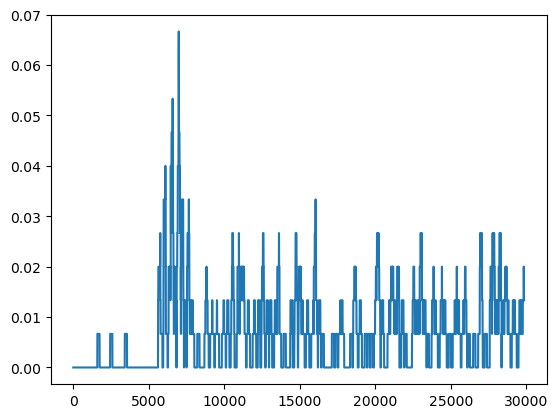

In [ ]:
plt.plot(window_avg(r_track, len(r_track) / 200))

In [ ]:
frames = []
done = False
s = encode_state([env.reset(seed=seed)[0]], state_size)
while not done:
    a = agent.act(s, eps=0.0)
    sp = encode_state([sp], state_size)
    sp, r, done, info, _ = env.step(a)
    frames.append(env.render()) 
    s = sp

plot_animation(frames, repeat=True, interval=100)